# Coursework Assignment: Building a Regression Model

```
University of London
BSc in Computer Science
CM3005, Data Science
Hudson Leonardo MENDES
hlm12@student.london.ac.uk
```


# I. Introduction


## Domain-specific area

Banks and Credit Institutions are often required to assess the values of properties in their portfolios by policymakers, concerned about their solvency, given that the collateral to the mortgages they trade are essentially properties themselves[[1](#ref:2007:hjort-et-al)]. However, Pension Funds[[2](#ref:2022:rastegar)] or any other company or person investing in real estate can benefit from understanding where the market trends are more likely heading.

The updated property prices must be predicted frequently and are traditionally processed using a system commercially known as an "Automated Valuation Model" (or AVM)[[1](#ref:2007:hjort-et-al), [3](#ref:web:rightmove-avm)]. These are either (a) a hedonic regression model, that regresses the transaction price from the set of features intrinsic to the property (e.g. the number of bedrooms), (b) a model focusing on repeated sales of the same property, to understand the price variations of the same object, (c) a hybrid model using features from both approaches, or (d) models including spatial methods [[1](#ref:2007:hjort-et-al)].

Hedonic regression relies on variables mapped to property prices linearly, and "the linear assumption can be unrealistic"[[1](#ref:2007:hjort-et-al)]. Recently Neural Networks have been suggested as an alternative for House Price Forecasting that resulted in a 1% Average Relative Root Mean Square Error across one hundred cities in China[[4](#ref:2021:xu-et-al)], perhaps suggesting the ability to break the linearity is a relevant component in house price predictions.

The present work presents two hedonic regression models, the first based on Polynomial Regression, and the second based on Multi-layer Perceptron Regression, both regressing property prices from intrinsic features of these properties, trained on the Price Paid Data[[5](#ref:web:uk-land-registry)] provided by the HM Land Registry in the United Kingdom.

## Dataset

In order to build a property price regressor, data related to property transactions was collected. The UK HM Land Registry department provides a high quality dataset in CSV format called **Price Paid Data**[[5](#ref:web:uk-land-registry)], containing information such as the date of the transaction, the type of the property, which looked, at first, relevant data to feed into a hendonic regressor.

Additionally, extra data was collected for information that would intuitively seem to be strongly correlated to variation in property prices, such as the **Interest Rate over Time**[[6](ref:web:uk-boe-interest)] and the **Inflation Rate over Time**[[7](#ref:web:uk-ons-cpih)], both known to be connected to the purchase power and, therefore, to demand.

### Price Paid Data

(table)

> Contains HM Land Registry data © Crown copyright and database right 2021. This data is licensed under the Open Government Licence v3.0.

### Interest Rate over Time

(table)

### Inflation Rate over Time

(table)

## Objectives


# II. Implementation


## Preprocessing


In [1]:
import pathlib

data_folderpath = pathlib.Path("./data")

ppd_folderpath = data_folderpath / "uk-ppd"
inflation_filepath = data_folderpath / "uk-ons/ons-inflation-1989-2022.csv"
interest_filepath = data_folderpath / "uk-boe/boe-interest-1975-2022.csv"


In [2]:
import pandas as pd

pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))


In [3]:
from tqdm import tqdm

tqdm.pandas()


In [32]:
from typing import Callable


def build_count_properties_sold(ix: pd.DataFrame, n_days: int) -> Callable[[pd.DataFrame], int]:
    def count_properties_sold(row: pd.DataFrame) -> int:
        if row.date and row.postgroup and row.property_type:
            slice = ix.loc[row.date - pd.Timedelta(days=n_days) : row.date, row.postgroup, row.property_type]
            return slice.sum()
        else:
            return None

    return count_properties_sold


# https://www.gov.uk/guidance/about-the-price-paid-data
ppd_property_type = {"D": "detached", "S": "semi-detached", "T": "terraced", "F": "flat/maisonettes"}
ppd_duration = {"F": "freehold", "L": "leasehold"}
ppd_old_or_new = {"Y": "new", "N": "old"}
ppd_cols_src = [
    "id",
    "price",
    "date",
    "postcode",
    "property_type",
    "old_or_new",
    "duration",
    "paon",
    "saon",
    "street",
    "locality",
    "town_city",
    "district",
    "county",
    "ppd_category_type",
    "record_status",
]
ppdf_cols_dst = [
    "date",
    "postgroup",
    "property_type",
    "old_or_new",
    "duration",
    "price",
]
ppd_filepaths = list(ppd_folderpath.glob("*.zip"))
ppd_df = pd.concat([pd.read_csv(fp, names=ppd_cols_src) for fp in tqdm(ppd_filepaths)])
ppd_df["postgroup"] = ppd_df["postcode"].progress_map(lambda x: str(x).split(" ")[0])
ppd_df["date"] = pd.to_datetime(ppd_df["date"])
ppd_df["property_type"] = ppd_df["property_type"].progress_map(ppd_property_type.get)
ppd_df["duration"] = ppd_df["duration"].progress_map(ppd_duration.get)
ppd_df["old_or_new"] = ppd_df["old_or_new"].progress_map(ppd_old_or_new.get)
ppd_df["price"] = ppd_df["price"].astype("float")
ppd_df = ppd_df[ppdf_cols_dst]
ppd_df = ppd_df.dropna()
ppd_df = ppd_df.astype({c: "category" for c in ["postgroup", "property_type", "old_or_new", "duration"]})
ppd_df.sample(n=5)


100%|██████████| 4597894/4597894 [00:05<00:00, 816126.00it/s]


,date,postgroup,property_type,old_or_new,duration,price
674484,2019-03-26,HP13,flat/maisonettes,old,leasehold,"218,000.000"
390791,2018-04-10,MK42,flat/maisonettes,new,leasehold,"135,600.000"
363186,2020-03-26,ST20,detached,old,freehold,"605,000.000"
936552,2018-10-16,L19,terraced,old,freehold,"108,000.000"
76746,2022-03-31,SN10,detached,old,freehold,"367,500.000"


In [5]:
import re
import string
from datetime import date

inflation_date_pattern = re.compile(r"([\d]{4})(?:\s+([\w]{3}))?")
inflation_month_names = [
    "JAN",
    "FEB",
    "MAR",
    "APR",
    "MAY",
    "JUN",
    "JUL",
    "AUG",
    "SEP",
    "OCT",
    "NOV",
    "DEC",
]
inflation_month_index = {mn: ix + 1 for (ix, mn) in enumerate(inflation_month_names)}
inflation_month_index["Q1"] = 1
inflation_month_index["Q2"] = 4
inflation_month_index["Q3"] = 7
inflation_month_index["Q3"] = 10

inflation_acceptable_numeric_chars = string.digits + ".,"


def extract_inflation_date(x: str) -> date:
    match = next(inflation_date_pattern.finditer(x), None)
    if match:
        group_count = len(match.groups())
        if group_count >= 1:
            year = int(match.group(1))
            month = 1
            month_name = match.group(2)
            if group_count > 1 and month_name:
                month_name = month_name.strip().upper()
                month = inflation_month_index.get(month_name)
            return date(year, month, 1)


def extract_inflation_rate(x: str) -> float:
    x = str(x)
    if all([c in inflation_acceptable_numeric_chars for c in x]):
        return float(x)
    return None


inflation_df = pd.read_csv(inflation_filepath)
inflation_df["date"] = inflation_df["Title"].map(extract_inflation_date)
inflation_df["date"] = pd.to_datetime(inflation_df["date"])
inflation_df["rate"] = inflation_df["CPIH ANNUAL RATE 00: ALL ITEMS 2015=100"].map(extract_inflation_rate)
inflation_df["rate"] = inflation_df["rate"].astype("float", errors="ignore")
inflation_df = inflation_df[["date", "rate"]]
inflation_df = inflation_df.dropna()
inflation_df = inflation_df.set_index("date").sort_index()
inflation_df.sample(n=5)


,rate
date,
1996-02-01,3.000
2007-11-01,2.200
1990-10-01,9.200
2004-06-01,1.500
2013-06-01,2.600


In [6]:
interest_df = pd.read_csv(interest_filepath)
interest_df["date"] = pd.to_datetime(interest_df["Date Changed"])
interest_df["rate"] = interest_df["Rate"].astype("float")
interest_df = interest_df[["date", "rate"]]
interest_df = interest_df.set_index("date").sort_index()
interest_df.sample(n=5)


,rate
date,
1982-02-22,13.810
2004-08-05,4.750
1990-10-08,13.880
2001-11-08,4.000
1999-02-04,5.500


In [33]:
from tqdm import tqdm, trange
from typing import Callable
from datetime import date, timedelta

tqdm.pandas()


def build_rate_extractor(df: pd.DataFrame) -> Callable[[date], float]:
    min_date = df.index.min()
    max_date = df.index.max()
    cur_date = min_date
    rate_index = {}
    first_rate = df.rate[0]
    prev_rate = first_rate
    last_rate = df.rate[-1]
    with trange((max_date - min_date).days, desc="rate_index") as pbar:
        while cur_date <= max_date:
            rates = df[df.index == cur_date].rate
            if rates.any():
                new_rate = rates[0] / 100.0
                rate_index[cur_date] = new_rate
                prev_rate = new_rate
            else:
                rate_index[cur_date] = prev_rate
            cur_date += timedelta(days=1)
            pbar.update()

    def get_rate_for_date(d: date) -> float:
        if d < min_date:
            return first_rate
        elif d > max_date:
            return last_rate
        else:
            return rate_index[d]

    return get_rate_for_date


df = ppd_df.copy()
df["inflation_rate"] = df.date.progress_map(build_rate_extractor(df=inflation_df))
df["interest_rate"] = df.date.progress_map(build_rate_extractor(df=interest_df))
df["date_year"] = df.date.progress_map(lambda d: d.year)
df["date_month"] = df.date.progress_map(lambda d: d.month)
df["date_day"] = df.date.progress_map(lambda d: d.day)
df["date_day_of_week"] = df.date.progress_map(lambda d: d.weekday())
df = df.sort_values(by="date").reset_index()
df = df[
    ["date_year", "date_month", "date_day", "date_day_of_week"]
    + list(ppd_df.columns[1:-1])
    + ["inflation_rate", "interest_rate", "price"]
]
df.sample(n=5)


rate_index: 12358it [00:06, 1804.61it/s]                           
100%|██████████| 4336841/4336841 [00:16<00:00, 261869.71it/s]
rate_index: 17497it [00:09, 1888.19it/s]                           
100%|██████████| 4336841/4336841 [00:14<00:00, 307827.74it/s]


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
3358301,2021,6,30,2,WD18,terraced,old,freehold,0.024,0.001,"712,000.000"
830920,2018,11,16,4,CR4,flat/maisonettes,old,leasehold,0.022,0.007,"240,000.000"
2123026,2020,4,17,4,HU7,terraced,old,freehold,0.009,0.001,"125,000.000"
450635,2018,7,4,2,CT15,semi-detached,old,freehold,0.023,0.005,"183,000.000"
2135799,2020,4,30,3,TA10,flat/maisonettes,old,leasehold,0.009,0.001,"95,000.000"


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336841 entries, 0 to 4336840
Data columns (total 11 columns):
 #   Column            Dtype   
---  ------            -----   
 0   date_year         int64   
 1   date_month        int64   
 2   date_day          int64   
 3   date_day_of_week  int64   
 4   postgroup         category
 5   property_type     category
 6   old_or_new        category
 7   duration          category
 8   inflation_rate    float64 
 9   interest_rate     float64 
 10  price             float64 
dtypes: category(4), float64(3), int64(4)
memory usage: 252.4 MB


In [9]:
df.to_csv(data_folderpath / "snapshot-Xy-1NF.zip", index=False)


## Statistical Summary


In [10]:
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd
    import numpy as np

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {"postgroup": "category", "property_type": "category", "old_or_new": "category", "duration": "category"}
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
3509870,2021,9,3,4,S11,flat/maisonettes,old,leasehold,0.029,0.001,"176,500.000"
2581946,2020,11,20,4,LL20,detached,old,freehold,0.006,0.001,"500,000.000"
2779182,2021,1,25,0,E10,flat/maisonettes,old,leasehold,0.009,0.001,"352,500.000"
1262876,2019,5,10,4,M29,semi-detached,old,leasehold,0.019,0.007,"159,950.000"
2968408,2021,3,19,4,BS7,terraced,old,freehold,0.010,0.001,"340,000.000"


In [11]:
df_feats_continuous = df.select_dtypes(include="float")
df_feats_continuous.sample(n=5)


,inflation_rate,interest_rate,price
820332,0.022,0.007,"450,000.000"
4075658,0.079,0.010,"327,500.000"
3460647,0.030,0.001,"380,000.000"
3013756,0.010,0.001,"325,000.000"
2037690,0.017,0.007,"117,500.000"


### Central Tendency


In [12]:
df_central_tendency = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.mean(), columns=["mean"]).transpose(),
        pd.DataFrame(df_feats_continuous.median(), columns=["median"]).transpose(),
        pd.DataFrame([df_feats_continuous[c].mode()[0] for c in df_feats_continuous.columns], columns=["mode"])
        .set_index(df_feats_continuous.columns)
        .transpose(),
    ]
)

df_central_tendency


,inflation_rate,interest_rate,price
mean,0.025,0.005,"318,106.045"
median,0.020,0.005,"247,000.000"
mode,0.023,0.001,"250,000.000"


### Measures of Spread


In [13]:
df_measures_of_spread = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.var(), columns=["var"]).transpose(),
        df_feats_continuous.describe(),
        pd.DataFrame(
            df_feats_continuous.quantile(0.75) - df_feats_continuous.quantile(0.25), columns=["IQR"]
        ).transpose(),
    ]
)


df_measures_of_spread


,inflation_rate,interest_rate,price
var,0.000,0.000,"159,733,778,805.720"
count,"4,336,841.000","4,336,841.000","4,336,841.000"
mean,0.025,0.005,"318,106.045"
std,0.020,0.004,"399,667.085"
min,0.005,0.001,1.000
25%,0.015,0.001,"160,000.000"
50%,0.020,0.005,"247,000.000"
75%,0.024,0.007,"376,999.000"
max,0.096,0.022,"165,000,000.000"
IQR,0.009,0.006,"216,999.000"


### Type of Distribution


In [14]:
df_types_of_distros = pd.concat(
    [
        pd.DataFrame(df_feats_continuous.skew(), columns=["skew"]).transpose(),
        pd.DataFrame(df_feats_continuous.kurtosis(), columns=["kurtosis"]).transpose(),
    ]
)

df_types_of_distros


,inflation_rate,interest_rate,price
skew,1.905,1.065,65.902
kurtosis,2.931,2.251,"17,380.070"


## Data visualisation


In [15]:
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {
            "postgroup": "category",
            "property_type": "category",
            "old_or_new": "category",
            "duration": "category",
            "price": "double",
        }
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
2707741,2020,12,18,4,HP21,semi-detached,old,freehold,0.008,0.001,"320,000.000"
1905918,2019,12,23,0,SK17,semi-detached,new,freehold,0.014,0.007,"252,995.000"
184195,2018,3,23,4,BS35,semi-detached,old,freehold,0.023,0.005,"340,000.000"
2494652,2020,10,23,4,LL13,semi-detached,old,freehold,0.009,0.001,"110,000.000"
4215291,2022,7,22,4,BD20,detached,old,freehold,0.088,0.013,"335,000.000"


In [16]:
df_feats_continuous = df.select_dtypes(include="float")
df_feats_continuous.sample(n=5)


,inflation_rate,interest_rate,price
2877612,0.007,0.001,"385,000.000"
2079296,0.015,0.001,"432,000.000"
3058827,0.016,0.001,"600,000.000"
2449060,0.009,0.001,"171,000.000"
1023632,0.018,0.007,"131,000.000"


In [17]:
%matplotlib inline

In [18]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter


### Comparison of Continuous Attributes


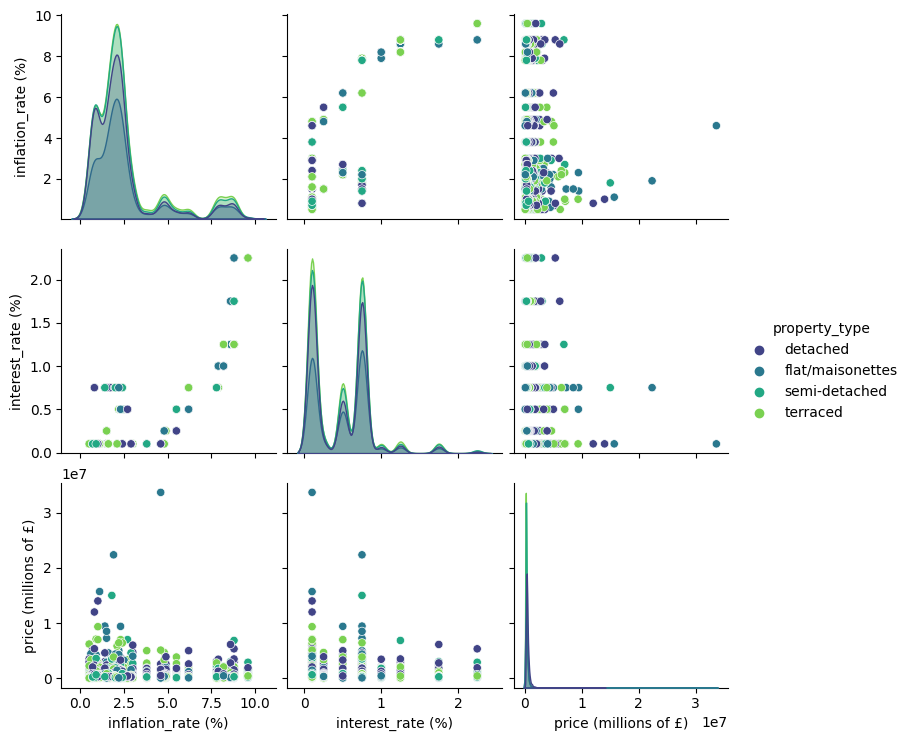

In [19]:
df_feats_cont_scal_pt = df[list(df_feats_continuous.columns) + ["property_type"]]
df_feats_cont_scal_pt = df_feats_cont_scal_pt.sample(n=int(df_feats_cont_scal_pt.shape[0] * 0.01))
df_feats_cont_scal_pt = df_feats_cont_scal_pt.copy()
df_feats_cont_scal_pt["inflation_rate"] *= 100.0
df_feats_cont_scal_pt["interest_rate"] *= 100.0
df_feats_cont_scal_pt.rename(
    columns={
        "inflation_rate": "inflation_rate (%)",
        "interest_rate": "interest_rate (%)",
        "price": "price (millions of £)",
    },
    inplace=True,
)
sns.pairplot(
    data=df_feats_cont_scal_pt,
    hue="property_type",
    kind="scatter",
    diag_kind="kde",
    palette="viridis",
)


### Distributions for Inflation Rate & Interest Rate


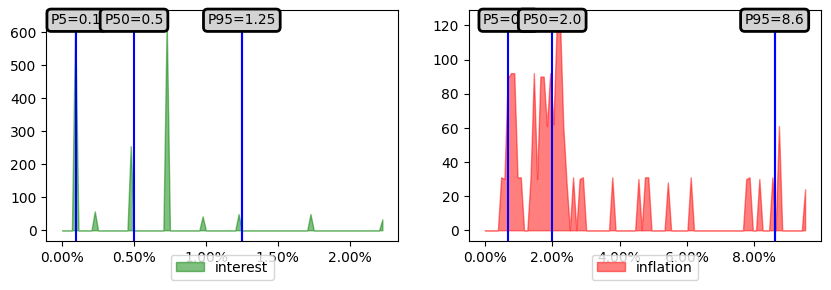

In [20]:
def plot_rate_distributions(ax, df: pd.DataFrame, label: str, color: str):
    df = df.copy()
    df["rate"] = df["rate"] * 100.0
    x = np.linspace(0.0, df["rate"].max(), 100)
    df["bin"] = pd.cut(df["rate"], bins=x)
    y = list(df.groupby("bin").count()["rate"])
    ax.fill_between(x[:-1], 0.0, y, color=color, alpha=0.5)
    ax.xaxis.set_major_formatter(FormatStrFormatter("%2.2f%%"))
    intervals = [0.05, 0.5, 0.95]
    for interval, quantile in zip(intervals, df.rate.quantile(intervals)):
        percentile = f"P{int(interval*100.)}={round(quantile, 2)}"
        bbox = dict(boxstyle="round, pad=0.3", fc="lightgray", lw=2)
        ax.axvline(x=quantile, color="blue")
        ax.annotate(
            percentile,
            xy=(quantile, max(y)),
            bbox=bbox,
            ha="center",
            va="center",
        )
    ax.axvline(x=quantile, color="blue")
    ax.legend([label], loc="lower center", bbox_to_anchor=(0.5, -0.2))


df_daily_means = df.groupby(["date_year", "date_month", "date_day"]).mean(numeric_only=True)
df_daily_means_interest = df_daily_means[["interest_rate"]].rename(columns={"interest_rate": "rate"})
df_daily_means_inflation = df_daily_means[["inflation_rate"]].rename(columns={"inflation_rate": "rate"})
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))
plot_rate_distributions(
    ax=axes[0],
    df=df_daily_means_interest,
    label="interest",
    color="green",
)
plot_rate_distributions(
    ax=axes[[1](#ref:2007:hjort-et-al)],
    df=df_daily_means_inflation,
    label="inflation",
    color="red",
)


### Time-Distribution Inflation, Interest & Property Price per Type


100%|██████████| 4/4 [00:00<00:00, 83.42it/s]


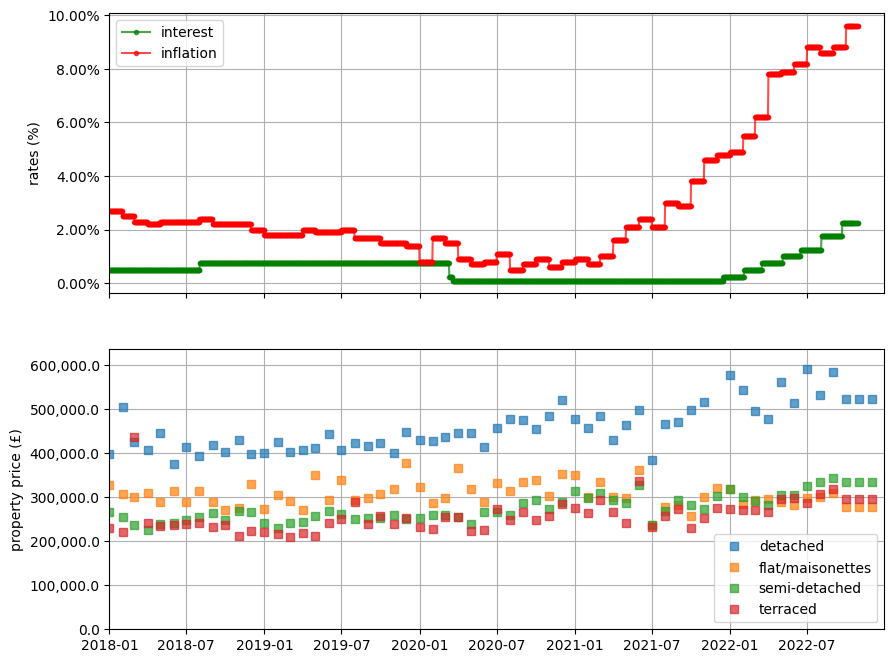

In [21]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import date


def plot_inflation_and_interest(
    ax: plt.Axes,
    df_mean_by_date: pd.DataFrame,
    xlim_left: float,
    xlim_right: float,
):
    df_mean_by_date = df_mean_by_date.reset_index()
    x = df_mean_by_date.apply(lambda r: date(int(r.date_year), int(r.date_month), int(r.date_day)), axis=1)
    ax.grid(visible=True)
    ax.plot(x, df_mean_by_date.interest_rate * 100.0, "g.-", alpha=0.7)
    ax.plot(x, df_mean_by_date.inflation_rate * 100.0, "r.-", alpha=0.7)
    ax.set_xlim(left=xlim_left, right=xlim_right)
    ax.set_ylabel("rates (%)")
    ax.yaxis.set_major_formatter(FormatStrFormatter("%2.2f%%"))
    ax.legend(["interest", "inflation"])


def plot_prices_per_property_type(
    ax: plt.Axes,
    df_mean_by_date_and_pt: pd.DataFrame,
):
    df_mean_by_date_and_pt = df_mean_by_date_and_pt.reset_index()
    ax.grid(visible=True)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,}"))
    ax.set_ylim(0.0, df_mean_by_date_and_pt.price.quantile(0.95) * 1.2)
    ax.set_ylabel("property price (£)")
    property_types = sorted(df_mean_by_date_and_pt.property_type.unique())
    for ix, property_type in tqdm(list(enumerate(property_types))):
        sub_series = df_mean_by_date_and_pt[df_mean_by_date_and_pt.property_type == property_type].copy()
        sub_series = sub_series.reset_index().groupby(["date_year", "date_month"]).mean(numeric_only=True).reset_index()
        sub_series = sub_series.fillna(method="ffill")
        x = sub_series.apply(lambda r: date(int(r.date_year), int(r.date_month), 1), axis=1)
        ax.plot(x, sub_series.price, "s", alpha=0.7)
        ax.legend(property_types)


min_intersecting_date = date(df.date_year.min(), 1, 1)
max_intersecting_date = date(df.date_year.max(), 12, 30)
_, axes = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)
plot_inflation_and_interest(
    ax=axes[0],
    df_mean_by_date=df.groupby(["date_year", "date_month", "date_day"]).mean(numeric_only=True),
    xlim_left=min_intersecting_date,
    xlim_right=max_intersecting_date,
)
plot_prices_per_property_type(
    ax=axes[[1](#ref:2007:hjort-et-al)],
    df_mean_by_date_and_pt=df.groupby(["date_year", "date_month", "date_day", "property_type"]).mean(numeric_only=True),
)


## Machine learning model


In [22]:
from datetime import datetime

r = 42
train_size = 0.99
experiment_name = f"exp-20221228_1755"
(experiment_name, r, train_size)


('exp-20221228_1755', 42, 0.99)

In [23]:
import pathlib

results_dir = pathlib.Path(f"./results/{experiment_name}")
results_dir.mkdir(parents=True, exist_ok=True)
results_dir


PosixPath('results/exp-20221228_1755')

In [24]:
try:
    assert df is not None
except NameError:
    import pathlib
    import pandas as pd
    import numpy as np

    print("[SNAPSHOT] Reloading...")
    pd.set_option("display.float_format", lambda x: "{:,.3f}".format(x))
    data_folderpath = pathlib.Path("./data")
    df = pd.read_csv(data_folderpath / "snapshot-Xy-1NF.zip").astype(
        {
            "postgroup": "category",
            "property_type": "category",
            "old_or_new": "category",
            "duration": "category",
            "price": "double",
        }
    )
    print(f" - reloaded from snapshot, {df.shape[0]}")
df.sample(n=5)


,date_year,date_month,date_day,date_day_of_week,postgroup,property_type,old_or_new,duration,inflation_rate,interest_rate,price
423820,2018,6,28,3,TR1,terraced,new,freehold,0.023,0.005,"194,250.000"
2116762,2020,4,9,3,L25,terraced,old,freehold,0.009,0.001,"145,000.000"
2648185,2020,12,8,1,RM16,semi-detached,old,freehold,0.008,0.001,"405,000.000"
1069775,2019,2,20,2,SK5,semi-detached,old,freehold,0.018,0.007,"149,950.000"
2666509,2020,12,11,4,BB12,semi-detached,old,freehold,0.008,0.001,"172,000.000"


### Feature Matrix & Targets


In [25]:
X, y = df[df.columns[:-1]], df[df.columns[-1]]
del df


### Hold-out Test-Sets


In [26]:
from typing import Tuple
from sklearn.model_selection import train_test_split


def produce_split_summary(
    X_split: pd.DataFrame, y_split: pd.DataFrame, name: str, total: int
) -> Tuple[str, int, int, str]:
    return (
        name,
        X_split.shape[0],
        y_split.shape[0],
        "{:.1f}%".format(100.0 * X_split.shape[0] / total),
    )


X1, X2, y1, y2 = train_test_split(X, y, train_size=train_size, random_state=r)
print(
    pd.DataFrame(
        [
            produce_split_summary(X, y, "full", total=X1.shape[0]),
            produce_split_summary(X1, y1, "train", total=X.shape[0]),
            produce_split_summary(X2, y2, "test", total=X.shape[0]),
        ],
        columns=["split", "|X|", "|y|", "%"],
    )
)
del X, y


   split      |X|      |y|       %
0   full  4336841  4336841  101.0%
1  train  4293472  4293472   99.0%
2   test    43369    43369    1.0%


### Model Pipeline


In [27]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [28]:
from typing import Tuple
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


def make_sine_cycle_encoder(period: int = 1) -> float:
    assert period != 0
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


# https://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use
def make_df_column_transformer(scale_non_categorical: bool = False):
    categorical_selector = make_column_selector(dtype_include="category")
    non_categorical_selector = make_column_selector(dtype_exclude="category")
    one_hot = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
    cycle_sine_12 = make_sine_cycle_encoder(period=12)
    cycle_sine_31 = make_sine_cycle_encoder(period=31)
    cycle_sine_6 = make_sine_cycle_encoder(period=6)
    steps = [
        (one_hot, categorical_selector),
        (cycle_sine_12, ["date_month"]),
        (cycle_sine_31, ["date_day"]),
        (cycle_sine_6, ["date_day_of_week"]),
    ]
    if scale_non_categorical:
        scaler = StandardScaler(with_mean=True, with_std=True)
        steps.append((scaler, non_categorical_selector))
    return make_column_transformer(*steps, remainder="passthrough")


def make_svd_polynomial_regression_model(
    random_state: int,
    svd_dims: int = 1,
    polynomial_degree: int = 1,
    fit_intercept: bool = False,
    verbose: bool = False,
):
    return make_pipeline(
        make_df_column_transformer(),
        TruncatedSVD(n_components=svd_dims, algorithm="arpack", random_state=r),
        PolynomialFeatures(degree=polynomial_degree, include_bias=False),
        LinearRegression(fit_intercept=fit_intercept),
        verbose=verbose,
    )


def make_mlp_regression_model(
    random_state: int,
    embedding_layer_dims: int = None,
    residual_layer_dims: int = 1,
    verbose: bool = False,
):
    hidden_layer_sizes = []
    if embedding_layer_dims:
        hidden_layer_sizes.append(embedding_layer_dims)
    if residual_layer_dims:
        hidden_layer_sizes.append(residual_layer_dims)
    return make_pipeline(
        make_df_column_transformer(scale_non_categorical=True),
        MLPRegressor(
            hidden_layer_sizes=tuple(hidden_layer_sizes),
            solver="adam",
            alpha=0.0001,
            max_iter=1,
            early_stopping=True,
            random_state=random_state,
            verbose=verbose,
        ),
        verbose=verbose,
    )


models = {
    "svd_polynomial_regression": make_svd_polynomial_regression_model(random_state=r, verbose=True),
    "mlp_regression": make_mlp_regression_model(random_state=r, verbose=True),
}
for model_name, model_instance in models.items():
    print(f"[{model_name}]")
    model_instance.fit(X1, y1)
    y1_pred = model_instance.predict(X1)
    y2_pred = model_instance.predict(X2)
    model_metrics = {
        "train": {
            "mae": mean_absolute_error(y1_pred, y1),
            "mape": mean_absolute_percentage_error(y1_pred, y1),
            "r2": mean_absolute_error(y1_pred, y1),
        },
        "test": {
            "mae": mean_absolute_error(y2_pred, y2),
            "mape": mean_absolute_percentage_error(y2_pred, y2),
            "r2": mean_absolute_error(y2_pred, y2),
        },
    }
    print(pd.DataFrame.from_dict(model_metrics))
del models
del model_metrics
del y1_pred, y2_pred


[svd_polynomial_regression]
[Pipeline] . (step 1 of 4) Processing columntransformer, total=  13.7s
[Pipeline] ...... (step 2 of 4) Processing truncatedsvd, total=   4.5s
[Pipeline]  (step 3 of 4) Processing polynomialfeatures, total=   0.0s
[Pipeline] .. (step 4 of 4) Processing linearregression, total=   0.3s
           train        test
mae  173,341.905 174,260.022
mape       0.545       0.548
r2   173,341.905 174,260.022
[mlp_regression]
[Pipeline] . (step 1 of 2) Processing columntransformer, total=  13.1s
Iteration 1, loss = 131560605211.27497864
Validation score: -0.741920
[Pipeline] ...... (step 2 of 2) Processing mlpregressor, total=  18.3s
           train        test
mae  318,083.011 318,492.447
mape  16,794.989  16,816.608
r2   318,083.011 318,492.447


### GridSearch with Cross-Validation


In [29]:
import json
import numpy as np
from datetime import datetime
from typing import List, Dict, Tuple, Any
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


def make_grid(
    model: Pipeline,
    param_grid: Dict[str, Any],
) -> GridSearchCV:
    return GridSearchCV(
        model,
        param_grid=param_grid,
        cv=5,
        scoring="neg_mean_absolute_percentage_error",
        verbose=3,
    )


def compile_best_metrics(
    grid: GridSearchCV,
    training_data: Tuple[np.array, np.array],
    test_data: Tuple[np.array, np.array],
) -> pd.DataFrame:
    X_train, y_true_train = training_data
    X_test, y_true_test = test_data
    y_pred_train = grid.predict(X_train)
    y_pred_test = grid.predict(X_test)
    return pd.DataFrame.from_dict(
        {
            "train": {
                "mae": mean_absolute_error(y_pred_train, y_true_train),
                "mape": mean_absolute_percentage_error(y_pred_train, y_true_train),
                "r2": r2_score(y_pred_train, y_true_train),
            },
            "test": {
                "mae": mean_absolute_error(y_pred_test, y_true_test),
                "mape": mean_absolute_percentage_error(y_pred_test, y_true_test),
                "r2": r2_score(y_pred_test, y_true_test),
            },
        }
    )


def compile_search_data(cv_results: Dict[str, Any]):
    df_search = pd.DataFrame.from_dict(cv_results)
    df_search = df_search.sort_values(by="rank_test_score").reset_index(drop=True)
    df_search_cols_key = ["rank_test_score"]
    df_search_cols_key.extend([c for c in df_search.columns.tolist() if c.startswith("param_")])
    df_search_cols_key.extend(["mean_test_score", "std_test_score"])
    df_results_cols_rest = [c for c in df_search.columns.tolist() if c not in df_search_cols_key]
    df_results_cols_rest.remove("params")
    return df_search[df_search_cols_key + df_results_cols_rest]


def export_grid_results(results_dir: pathlib.Path, experiment_name: str, results: List[Tuple[str, pd.DataFrame]]):
    experiment_dir = results_dir / experiment_name
    experiment_dir.mkdir(parents=True, exist_ok=True)
    for result_name, result_df in results:
        result_df.to_csv(experiment_dir / f"{result_name}.csv")


def run_grid_experiment(
    experiment: str,
    model: Pipeline,
    training_data: Tuple[np.array, np.array],
    test_data: Tuple[np.array, np.array],
    param_grid: Dict[str, Any],
    results_dir: pathlib.Path,
):
    print(f"[{experiment}]")
    grid = make_grid(model, param_grid)
    X_train, y_train = training_data
    grid.fit(X_train, y_train)
    df_best_params = pd.DataFrame.from_dict(grid.best_params_, orient="index")
    df_best_metrics = compile_best_metrics(grid, training_data, test_data)
    df_search_data = compile_search_data(grid.cv_results_)
    export_grid_results(
        results_dir=results_dir,
        experiment_name=experiment,
        results=[
            ("best-params", df_best_params),
            ("best-metrics", df_best_metrics),
            ("search-data", df_search_data),
        ],
    )
    return df_best_metrics


### Grid Search: Polynomial Linear Regression


In [30]:
model = make_svd_polynomial_regression_model(random_state=r)


In [ ]:
run_grid_experiment(
    experiment=f"svd_polynomial_regression_canary",
    model=model,
    training_data=(X1[0:5000], y1[0:5000]),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [[1](#ref:2007:hjort-et-al)],
        "polynomialfeatures__degree": [[1](#ref:2007:hjort-et-al)],
        "linearregression__fit_intercept": [False],
    },
    results_dir=results_dir,
)


/var/folders/gt/j16393sd52s3xsm_3fsd_3qr0000gn/T/ipykernel_22899/1565712382.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  training_data=(X1[0:5000], y1[0:5000]),


[svd_polynomial_regression_canary]
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.836 total time=   0.1s
[CV 2/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.892 total time=   0.0s
[CV 3/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.837 total time=   0.1s
[CV 4/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.803 total time=   0.1s
[CV 5/5] END linearregression__fit_intercept=False, polynomialfeatures__degree=1, truncatedsvd__n_components=1;, score=-0.799 total time=   0.1s


,train,test
mae,"173,160.978","174,395.551"
mape,0.544,0.547
r2,"-5,048,658.856","-4,409,838.730"


In [ ]:
run_grid_experiment(
    experiment=f"svd_polynomial_regression_sm",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [3],
        "polynomialfeatures__degree": [1, 2, 3],
        "linearregression__fit_intercept": [True, False],
    },
    results_dir=results_dir,
)


[svd_polynomial_regression_sm]
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-1.196 total time=  10.7s
[CV 2/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-1.551 total time=  11.9s
[CV 3/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-2.336 total time=  10.8s
[CV 4/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-0.827 total time=  11.4s
[CV 5/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=1, truncatedsvd__n_components=3;, score=-1.552 total time=  11.7s
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=2, truncatedsvd__n_components=3;, score=-1.195 total time=  15.5s
[CV 2/5] END linearregression__fit_intercept=

,train,test
mae,"171,718.854","172,698.039"
mape,0.540,0.543
r2,-169.194,-212.548


In [ ]:
run_grid_experiment(
    experiment=f"svd_polynomial_regression_md",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [4, 5, 6],
        "polynomialfeatures__degree": [3],
        "linearregression__fit_intercept": [True, False],
    },
    results_dir=results_dir,
)


[svd_polynomial_regression_md]
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-1.102 total time=  34.9s
[CV 2/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-1.471 total time=  30.9s
[CV 3/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-2.340 total time=  26.1s
[CV 4/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-0.802 total time=  22.8s
[CV 5/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=4;, score=-1.324 total time=  23.3s
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=3, truncatedsvd__n_components=5;, score=-1.127 total time=  38.8s
[CV 2/5] END linearregression__fit_intercept=

,train,test
mae,"159,951.421","161,246.722"
mape,0.509,0.514
r2,-19.009,-24.136


In [ ]:
run_grid_experiment(
    experiment=f"svd_polynomial_regression_lg",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "truncatedsvd__n_components": [4, 5],
        "polynomialfeatures__degree": [4],
        "linearregression__fit_intercept": [True, False],
    },
    results_dir=results_dir,
)


[svd_polynomial_regression_lg]
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-1.088 total time=  55.4s
[CV 2/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-1.449 total time=  50.3s
[CV 3/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-2.323 total time=  50.7s
[CV 4/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-0.801 total time=  48.4s
[CV 5/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=4;, score=-1.317 total time=  46.6s
[CV 1/5] END linearregression__fit_intercept=True, polynomialfeatures__degree=4, truncatedsvd__n_components=5;, score=-1.105 total time= 3.1min
[CV 2/5] END linearregression__fit_intercept=

,train,test
mae,"169,389.066","170,279.231"
mape,0.532,0.535
r2,-71.545,-89.154


### Grid Searrch: MLP Regression


In [31]:
model = make_mlp_regression_model(random_state=r)


In [ ]:
run_grid_experiment(
    experiment=f"mlp_regression_emb_only",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(2,), (4,), (8,)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_emb_only]
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.040 total time= 4.0min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.505 total time= 6.2min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.000 total time= 3.3min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.692 total time= 3.9min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.286 total time= 3.8min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2,

,train,test
mae,"154,364.527","155,374.364"
mape,0.478,0.481
r2,-39.092,-49.907


In [ ]:
run_grid_experiment(
    experiment=f"mlp_regression_sm",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(2, 2), (2, 4)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_sm]
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.684 total time= 5.4min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.637 total time= 7.2min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.893 total time= 6.9min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.308 total time= 4.4min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(2, 2), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.792 total time= 4.4min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=

,train,test
mae,"99,549.909","100,044.293"
mape,0.328,0.327
r2,-1.541,-2.472


In [ ]:
run_grid_experiment(
    experiment=f"mlp_regression_md",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(4, 4), (4, 8)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_sm]
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.733 total time= 9.7min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.690 total time= 9.6min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.962 total time=11.1min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.347 total time= 9.3min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(4, 4), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.761 total time= 9.8min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=

,train,test
mae,"89,541.390","90,766.460"
mape,0.260,0.262
r2,-0.590,-1.255


In [ ]:
run_grid_experiment(
    experiment=f"mlp_regression_lg",
    model=model,
    training_data=(X1, y1),
    test_data=(X2, y2),
    param_grid={
        "mlpregressor__hidden_layer_sizes": [(8, 8), (8, 16)],
        "mlpregressor__solver": ["adam", "lbfgs"],
        "mlpregressor__alpha": [0.0001, 0.001, 0.01, 0.1],
        "mlpregressor__max_iter": [25],
    },
    results_dir=results_dir,
)


[mlp_regression_lg]
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.598 total time=10.3min
[CV 2/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.649 total time=11.2min
[CV 3/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-1.676 total time=15.3min
[CV 4/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.298 total time=10.2min
[CV 5/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=(8, 8), mlpregressor__max_iter=25, mlpregressor__solver=adam;, score=-0.744 total time=10.2min
[CV 1/5] END mlpregressor__alpha=0.0001, mlpregressor__hidden_layer_sizes=

,train,test
mae,"89,136.722","90,317.630"
mape,0.261,0.262
r2,-0.480,-1.075


### Combining Grid Search Results

# III. Conclusions


## Performance of results


## Closing remarks/statements


# IV. References

<a id="ref:2007:hjort-et-al"></a>
```
[[1](#ref:2007:hjort-et-al)] Anders Hjort, Johan Pensar, Ida Scheel & Dag Einar Sommervoll (2022) 'House price prediction with gradient boosted trees under different loss functions', Journal of Property Research, 39:4, 338-364, DOI: 10.1080/09599916.2022.2070525. Source: https://www.tandfonline.com/doi/pdf/10.1080/09599916.2022.2070525
```

<a id="ref:2022:rastegar"></a>
```
[2](#ref:2022:rastegar) Rastegar, Kellie. 'Why Large Pension Funds Are Investing In Private Real Estate', Forbes, 2022. Source: https://www.forbes.com/sites/forbesbusinesscouncil/2022/02/14/why-large-pension-funds-are-investing-in-private-real-estate/?sh=2d5cd1a11e45
```

<a id="ref:web:rightmove-avm"></a>
```
[3] AVM, Automated Valuation Model Service by RightMove. Source: https://www.rightmove.co.uk/property-data/automated-valuation-model/
```
<a id="ref:2021:xu-et-al"></a>
```
[4] Xu, Xiaojie, and Yun Zhang. ‘House Price Forecasting with Neural Networks’. Intelligent Systems with Applications, vol. 12, 2021, p. 200052, https://doi.org10.1016/j.iswa.2021.200052.
Source: https://reader.elsevier.com/reader/sd/pii/S2667305321000417?token=3FC43BE0FD2A4CFD9181E501BDEAE82235A2E12119F2570BEA114D70B8C1B622FB91CB03A10C5EDB66134567FF2D49AD&originRegion=eu-west-1&originCreation=20230102163119
```

<a id="ref:web:uk-land-registry"></a>
```
[5] "Price Paid Data", Last updated
30 December 2022, HM Land Registry. Source: https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads
```

<a id="ref:web:uk-boe-interest"></a>
```
[6] "Official Bank Rate history". Bank of England, 2022. Source: https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp
```

<a id="ref:web:uk-ons-cpih"></a>
```
[7] "CPIH ANNUAL RATE 00: ALL ITEMS 2015=100", Office for National Statistics, 2022. Source: https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23
```